# Channing House Data

This is the `channing` dataset in the R package [boot](https://cran.r-project.org/web/packages/boot/index.html).
From the package description:
    
> Channing House is a retirement centre in Palo Alto, California.
> These data were collected between the opening of the house in 1964 until July 1, 1975.
> In that time 97 men and 365 women passed through the centre.
> For each of these, their age on entry and also on leaving or death was recorded.
> A large number of the observations were censored mainly due to the resident being alive on July 1, 1975 when the data was collected.
> Over the time of the study 130 women and 46 men died at Channing House.
> Differences between the survival of the sexes, taking age into account, was one of the primary concerns of this study."

These data feature *left truncation* because residents entered Channing House at different ages, and their lifetimes were not observed before entry.
This is a biased sampling problem since there are no observations on individuals who died before potentially entering Channing House.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

from survive import datasets
from survive import SurvivalData
from survive import KaplanMeier, NelsonAalen

## Loading the Dataset

The `channing()` function in the `survive.datasets` module loads a `pandas.DataFrame` containing the Channing House data.
The columns of this `DataFrame` are

* `sex` - Sex of each resident (male or female).
* `entry` - The resident's age (in months) on entry to the centre.
* `exit` - The age (in months) of the resident on death, leaving the centre or July 1, 1975 whichever event occurred first.
* `time` - The length of time (in months) that the resident spent at Channing House (this is `exit - entry`).
* `status` - Right-censoring indicator. 1 indicates that the resident died at Channing House, 0 indicates that they left the house prior to July 1, 1975 or that they were still alive and living in the centre at that date.

In [2]:
channing = datasets.channing()
channing.head()

,sex,entry,exit,time,status
resident,,,,,
0,male,782,909,127,1
1,male,1020,1128,108,1
2,male,856,969,113,1
3,male,915,957,42,1
4,male,863,983,120,1


## Exploratory Data Analysis

We use the Channing House data to create a `SurvivalData` object.

In [3]:
surv = SurvivalData(time="exit", entry="entry", status="status", group="sex",
                    data=channing)
print(surv)

female

 798+  804   804+  812+  819+  821+  822   824+  825+  829+  830   836+
 840   845   848+  848+  854+  857+  860+  861   861+  868   870+  870+
 872+  873   874+  875+  876+  882+  883   885   888+  891+  891+  892+
 893+  895   895+  897   897+  898+  899+  901   904+  905   905   905+
 905+  905+  906+  908   908   911   912+  912+  912+  913+  914+  915 
 916+  917+  918+  919   919+  922+  923   924+  925+  926   926+  926+
 926+  927+  927+  927+  928   928+  929+  930   930+  931   932   932+
 932+  932+  933+  934   934+  936   938+  938+  938+  939+  939+  940 
 940+  941   942+  943+  944   944   944+  944+  945+  946+  947+  948 
 948+  948+  950+  950+  952+  952+  953+  953+  954   954+  955+  955+
 955+  957+  957+  958+  958+  959   959+  959+  960+  961+  961+  962+
 963   963+  964+  965+  965+  966   967+  969   969   970   970+  971+
 971+  973+  973+  975   975+  975+  976   976+  976+  976+  977+  977+
 978   978+  979+  979+  979+  981+  982   982   982+  9

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/survive-0.3-py3.7.egg/survive/survival_data.py:183: RuntimeWarning: Ignoring 5 observations where entry >= time.
  RuntimeWarning)


The warning here is due to the fact that five of the observations in the data have entry times that are the same or later than the corresponding final times.
These observations consequently cannot be used.

In [4]:
# The five observations responsible for the warning above
display(channing.loc[channing.exit <= channing.entry])

,sex,entry,exit,time,status
resident,,,,,
56,male,953,953,0,0
351,female,957,957,0,0
372,female,944,944,0,0
373,female,935,935,0,0
433,female,959,912,53,1


The last line above doesn't even make sense since the entry time (959) is greater than the exit time (912).
The resident's duration is 53, which suggests that the entry time is likely supposed to be 859 (after all, 859+53=912).
Nevertheless, we will ignore this observation.

In [5]:
display(surv.describe)

,total,events,censored
group,,,
female,361,129,232
male,96,46,50


### Plotting the At-Risk Process

Due to the left-truncation, the risk set size initially increases as residents enter Channing House and then decreases as residents die or are censored.

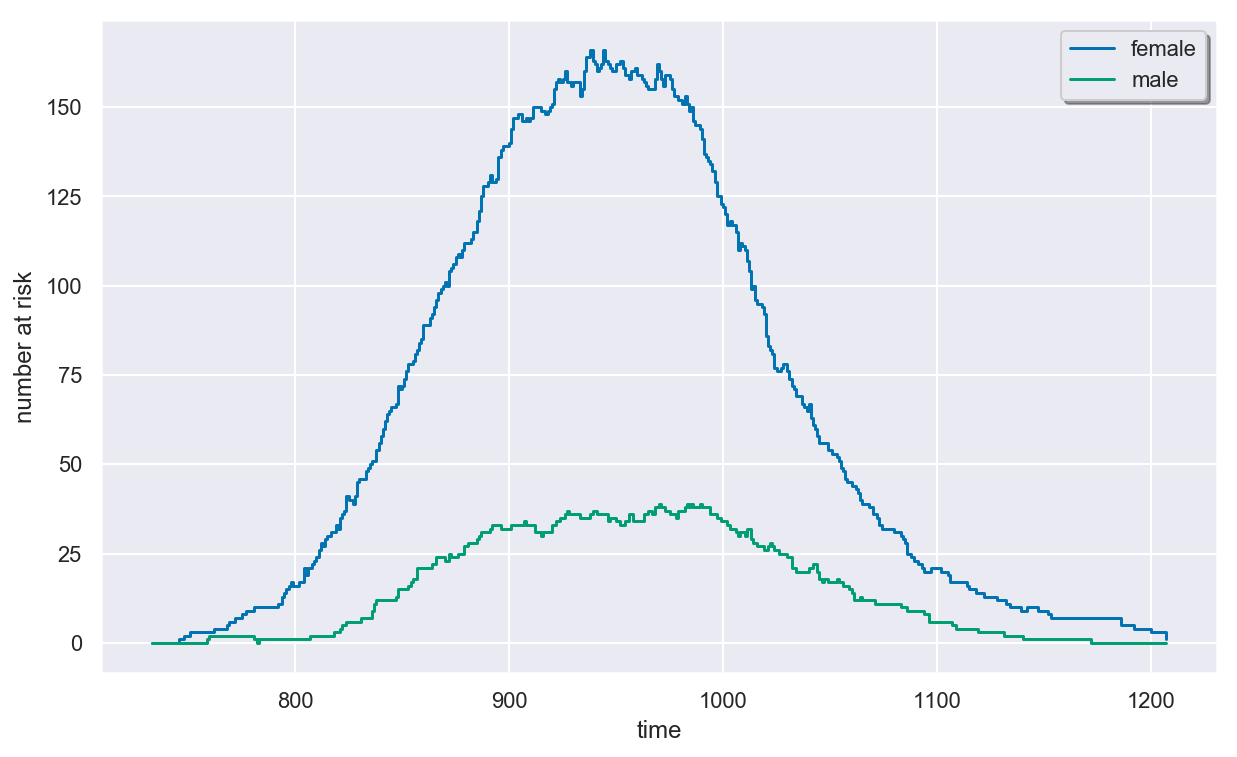

In [6]:
plt.figure(figsize=(10, 6))
colors = dict(female="b", male="g")
surv.plot_at_risk(colors=colors)
plt.show()
plt.close()

## Estimating the survival function

The out-of-the-box Kaplan-Meier estimator does a poor job estimating the survival function for the Channing House data because risk set of the male residents is zero very early on before growing.
This causes the survival function estimate to be zero for most of the observed times, which is clearly wrong.
We will show the problem graphically in this case and then discuss how to fix it.

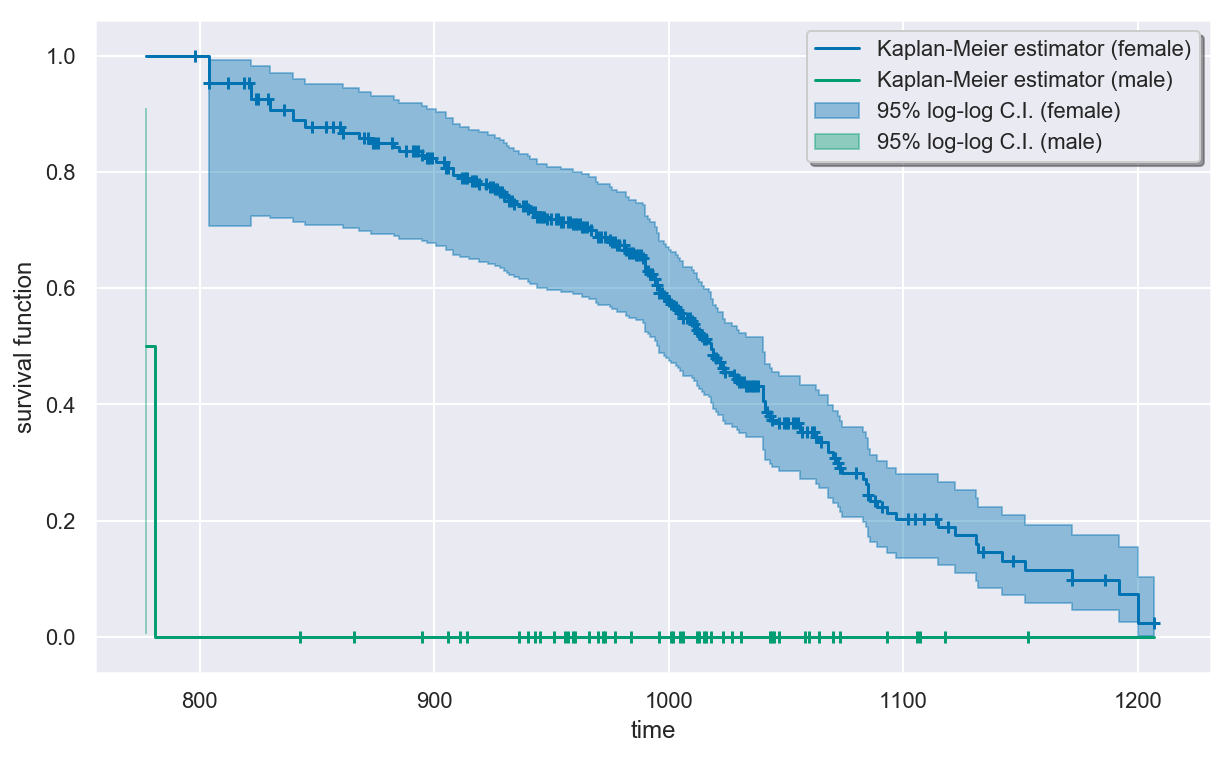

In [7]:
km = KaplanMeier().fit(surv)

plt.figure(figsize=(10, 6))
km.plot(colors=colors)
plt.show()
plt.close()

One way to address this issue is to condition on survival up to a later time, say 68 or 80 years (816 or 960 months).

In [8]:
km68 = KaplanMeier()
km68.fit(time="exit", entry="entry", status="status", group="sex",
         data=channing, min_time=816, warn=False)

KaplanMeier(conf_level=0.95, conf_type='log-log', n_boot=500,
            random_state=None, tie_break='discrete', var_type='greenwood')

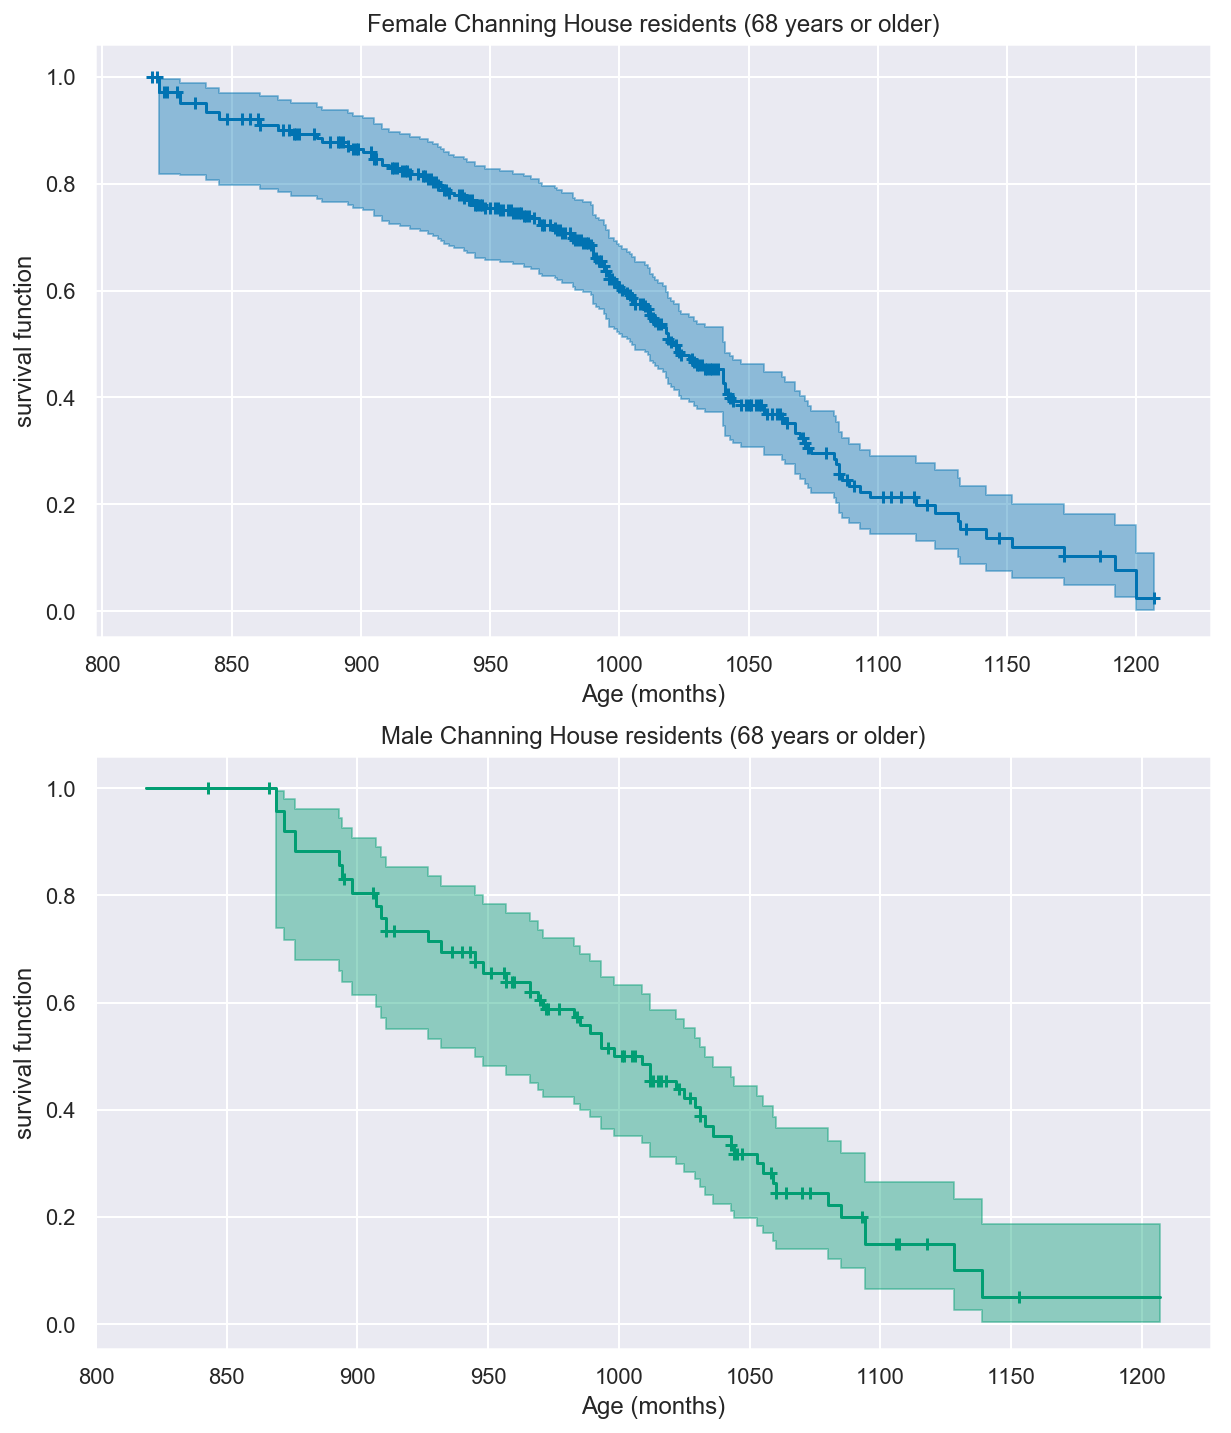

In [9]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

km68.plot("female", color=colors["female"], ax=ax[0])
ax[0].set(title="Female Channing House residents (68 years or older)")
ax[0].set(xlabel="Age (months)")

km68.plot("male", color=colors["male"], ax=ax[1])
ax[1].set(title="Male Channing House residents (68 years or older)")
ax[1].set(xlabel="Age (months)")

plt.show()
plt.close()

In [10]:
km80 = KaplanMeier()
km80.fit(time="exit", entry="entry", status="status", group="sex",
         data=channing, min_time=960)

KaplanMeier(conf_level=0.95, conf_type='log-log', n_boot=500,
            random_state=None, tie_break='discrete', var_type='greenwood')

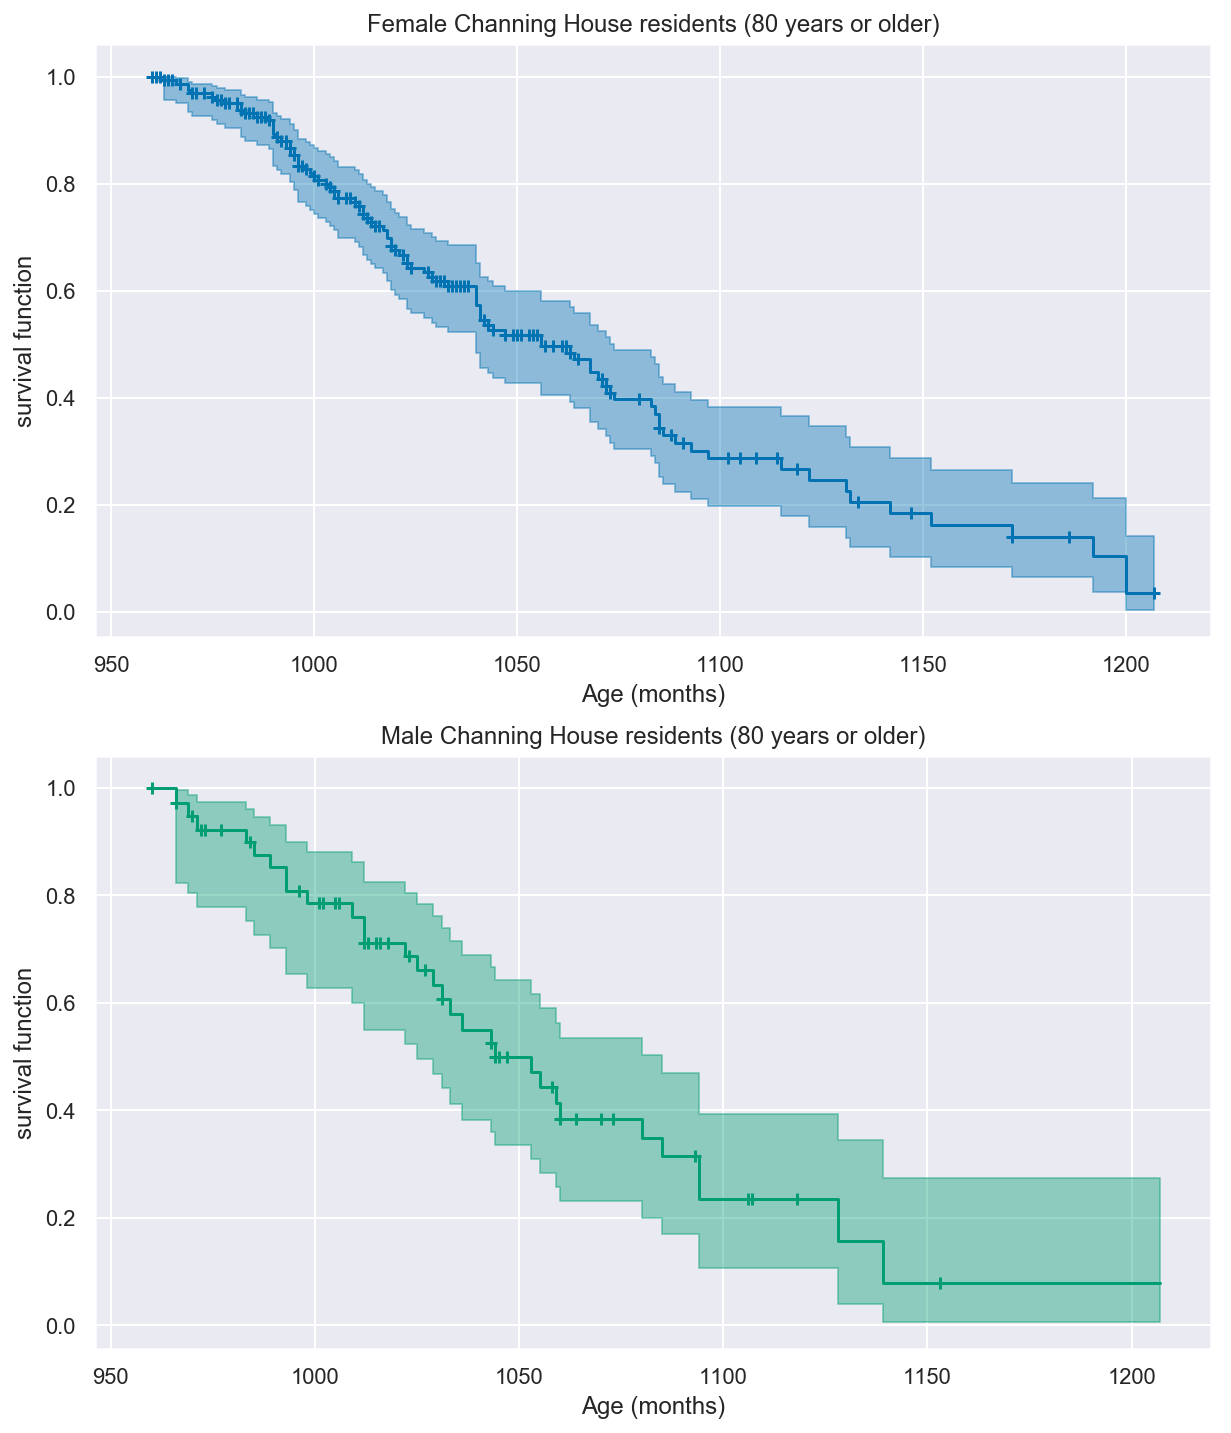

In [11]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

km80.plot("female", color=colors["female"], ax=ax[0])
ax[0].set(title="Female Channing House residents (80 years or older)")
ax[0].set(xlabel="Age (months)")

km80.plot("male", color=colors["male"], ax=ax[1])
ax[1].set(title="Male Channing House residents (80 years or older)")
ax[1].set(xlabel="Age (months)")

plt.show()
plt.close()

## Estimating the cumulative hazard

In [12]:
na = NelsonAalen(var_type="greenwood")
na.fit(surv)

NelsonAalen(conf_level=0.95, conf_type='log', tie_break='discrete',
            var_type='greenwood')

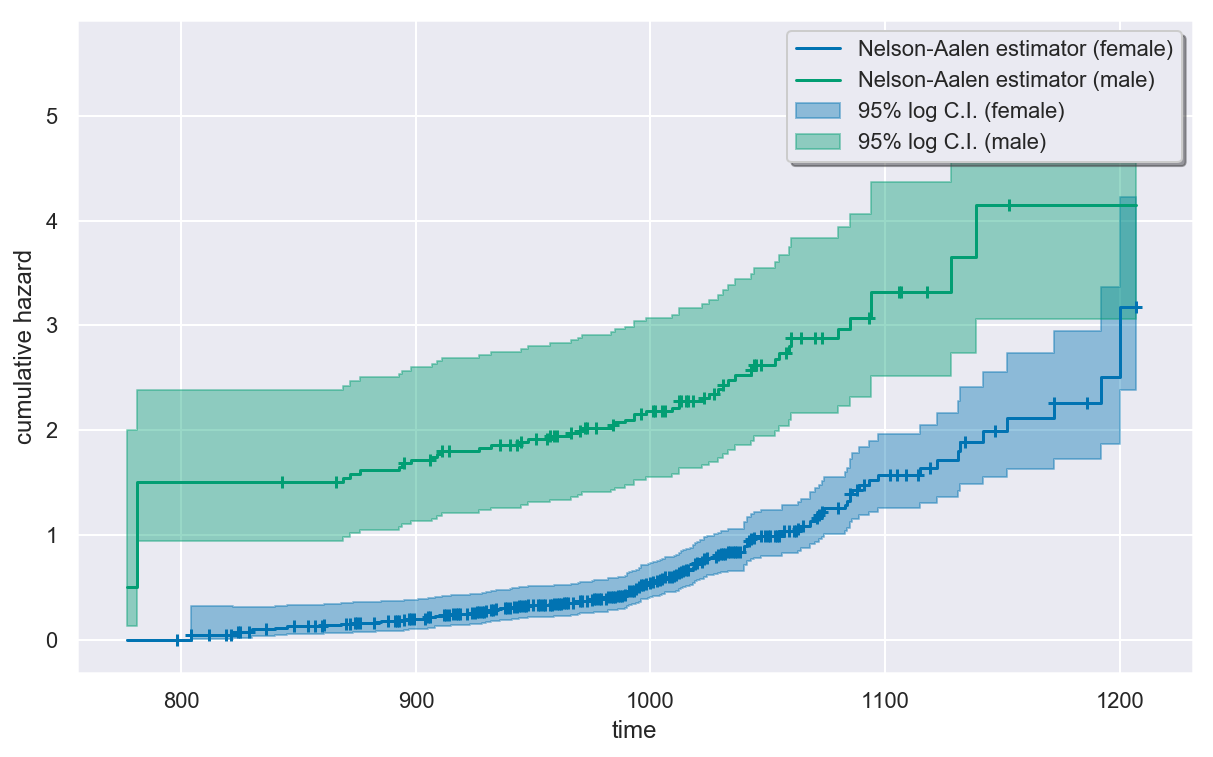

In [13]:
plt.figure(figsize=(10, 6))
na.plot(colors=colors)
plt.show()
plt.close()